导入库，数据

In [1]:
import scipy.io as spio         #该库用于load MAT文件
import numpy as np              #常规数据库
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
emgE1=spio.loadmat('S8_E1_A1.mat')
emgE2=spio.loadmat('S8_E2_A1.mat')
emgE3=spio.loadmat('S8_E3_A1.mat')
print(emgE1.keys())

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


整合一个受试者数据的函数（将三个动作组和标签整合到一起，并去除休息片段）

In [3]:
def extractData(emgE1,emgE2,emgE3):
    #提取对应的标签数据
    label1=emgE1['restimulus']
    label2=emgE2['restimulus']
    label3=emgE3['restimulus']

    #提取三个Exercise的emg信号数据
    emg1=emgE1['emg']
    emg2=emgE2['emg']
    emg3=emgE3['emg']

    #创建空实例，用来存储动作数据
    E1=[]
    E2=[]
    E3=[]
    L1=[]
    L2=[]
    L3=[]

    #将休息片段（即：标签数据为0的部分）去除，只保留动作
    #每个动作组的长度不一致，单独创建循环

    for i in range(len(label1)):
        if label1[i] != 0:
            E1.append(emg1[i,:])
            L1.append(label1[i,:])
    E1=np.array(E1)                 #将list转换成array
    L1=np.array(L1)                 #将list转换成array

    for i in range(len(label2)):
        if label2[i] != 0:
            E2.append(emg2[i,:])
            L2.append(label2[i,:])
    E2=np.array(E2)
    L2=np.array(L2)

    for i in range(len(label3)):
        if label3[i] != 0:
            E3.append(emg3[i,:])
            L3.append(label3[i,:])
    E3=np.array(E3)
    L3=np.array(L3)

    #将三组动作整合成一个，标签也一样，并将标签的数值从0开始，一共49个动作
    EMG = np.vstack((E1,E2,E3))
    LABEL = np.vstack((L1,L2,L3))
    LABEL = LABEL - 1 
    return EMG, LABEL

(2610207, 12)
(2610207, 1)
[ 2.5949983e-05  1.8889290e-07 -4.1185751e-07  2.2581503e-06
 -3.9826961e-07 -8.3492450e-06  1.7303211e-05 -2.8272721e-06
 -3.8891358e-06  6.5888016e-06 -3.6520630e-06  2.6888220e-06]


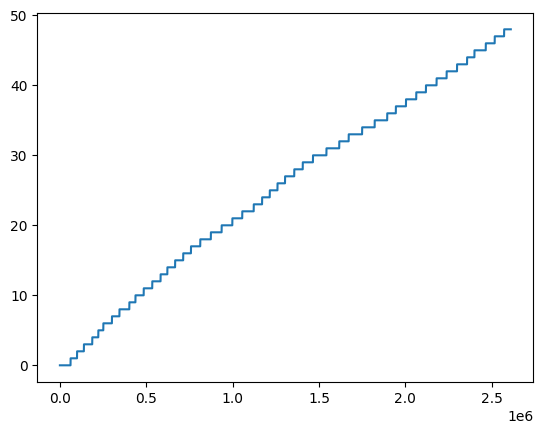

In [4]:
#打印数据形状
EMG,LABEL=extractData(emgE1,emgE2,emgE3)
print(EMG.shape)
print(LABEL.shape)
print(EMG[1,:])
plt.plot(LABEL)

定义时域特征计算函数，为了保证提取特征的连续性，采用时间窗方法

In [5]:
print(LABEL)

[[ 0]
 [ 0]
 [ 0]
 ...
 [48]
 [48]
 [48]]


转化为图像数据

In [6]:
def getImage(data,label,image_length,k):
    #初始化数据结构
    imageData=[]
    imageLabel=[]
    length = image_length
    datalength=label.shape[0]
    
    #原始数据准备, 将数据放大以便分析
    data = data*20000
            
    #为了保证数据的相关性，遍历类别，对每个类别执行操作
    #如：姿势1的emg信号与姿势2的分开进行图像化处理
    #以此防止干扰模型的判断
    for i in range(k):
        index = []
        for j in range(datalength):
            #提取类别特定的样本索引
            if (label[j] == i):
                index.append(j)
        #提取类别特定标签下的EMG数据
        seg_emg = data[index,:]
        
        #计算可提取的图像样本数量
        #剔除每个动作结束阶段的窗口数据
        #是因为该部分可能包含姿势变换期间产生的非典型EMG信号，导致数据可靠性存疑。
        num_windows = (seg_emg.shape[0] - length) // length

        #提取图像样本
        for j in range(num_windows):
            #图像数据点的开头和结尾，单个图像形状为[200,12]
            initial = length*j
            end = length*(j+1)
            #生成图像数据
            image = seg_emg[initial:end,:]
            #储存图像数据和对应标签至列表
            imageData.append(image)
            imageLabel.append(i)
    
    #数据转换
    imageData = np.array(imageData)
    imageLabel = np.array(imageLabel)
    imageLabel = imageLabel.reshape(-1, 1)
    return imageData, imageLabel

In [7]:
image_length=200
classes = 49
imageData,imageLabel = getImage(EMG,LABEL,image_length,classes)

In [8]:
print(imageData.shape)
print(imageLabel.shape)
print(imageLabel)

(12980, 200, 12)
(12980, 1)
[[ 0]
 [ 0]
 [ 0]
 ...
 [48]
 [48]
 [48]]


In [9]:
import h5py
#file = h5py.File('DB2_S2_feature_200_0.h5','w')  
#file.create_dataset('featureData', data = featureData)  
#file.create_dataset('featureLabel', data = featureLabel)  
#file.close()  

file = h5py.File('DB2_S8_image_200_0.h5','w')  
file.create_dataset('imageData', data = imageData)  
file.create_dataset('imageLabel', data = imageLabel)  
file.close()  
